## Bonn Database Analysis

#### Importing Libraries

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import welch, butter, filtfilt, decimate
from keras import models, layers, optimizers, losses, metrics
from sklearn.model_selection import train_test_split

#### Importing data from the Bonn Database

In [10]:
# Defining directories
directories = ['Z', 'O', 'N', 'F', 'S']
base_path = './bonn_database/'

# Initialize dictionaries to store data
data_dict = {
# healthy volunteer data
    "Z": [],  # eyes open
    "O": [],  # eyes closed
# presurgical diagnosis data
    "N": [],  # not seizure - within the lesion area (hipocampus)
    "F": [],  # not seizure - within the other hemisphere's hipocampus
    "S": []   # seizure data
}

original_fs = 173.61 # sampling frequency

# Reading data from each directory
for dir_name in directories:
    dir_path = os.path.join(base_path, dir_name)
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        data = np.loadtxt(file_path)
        data_dict[dir_name].append(data)

# Convert lists to numpy ndarrays
for key in data_dict.keys():
    data_dict[key] = np.array(data_dict[key])

# Print shapes of data for verification
for key, value in data_dict.items():
    print(f" Data {key} shape: {value.shape}")

 Data Z shape: (100, 4097)
 Data O shape: (100, 4097)
 Data N shape: (100, 4097)
 Data F shape: (100, 4097)
 Data S shape: (100, 4097)


#### Filtering and downsampling the data

In [11]:
# defines the filter to be used
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [14]:
# filtering step
lowcut = 0.5
highcut = 40
down_factor = 2 # downsampling factor

filt_dict = {key: decimate(bandpass_filter(data, lowcut, highcut, original_fs), down_factor)
             for key, data in data_dict.items()}

fs = original_fs / down_factor

### Visualizing the EEG's and their spectrum

This is important so we can see the 2 features we are working with:
- The EEG's (raw, time-based data)
- The spectrum of the EEG's (frequency domain data)

In [19]:
# calculates the power spectral density for each data
psd_dict = {}

frequencies = []

for key, item in filt_dict.items():
    frequencies, psd_dict[key] = welch(item, fs=fs, nperseg=256)

print(f"PSD Z shape: {psd_dict["Z"].shape}")
# print(frequencies) # 0-43 Hz, near Nyquist frequency


PSD Z shape: (100, 129)


#### Plotting Samples

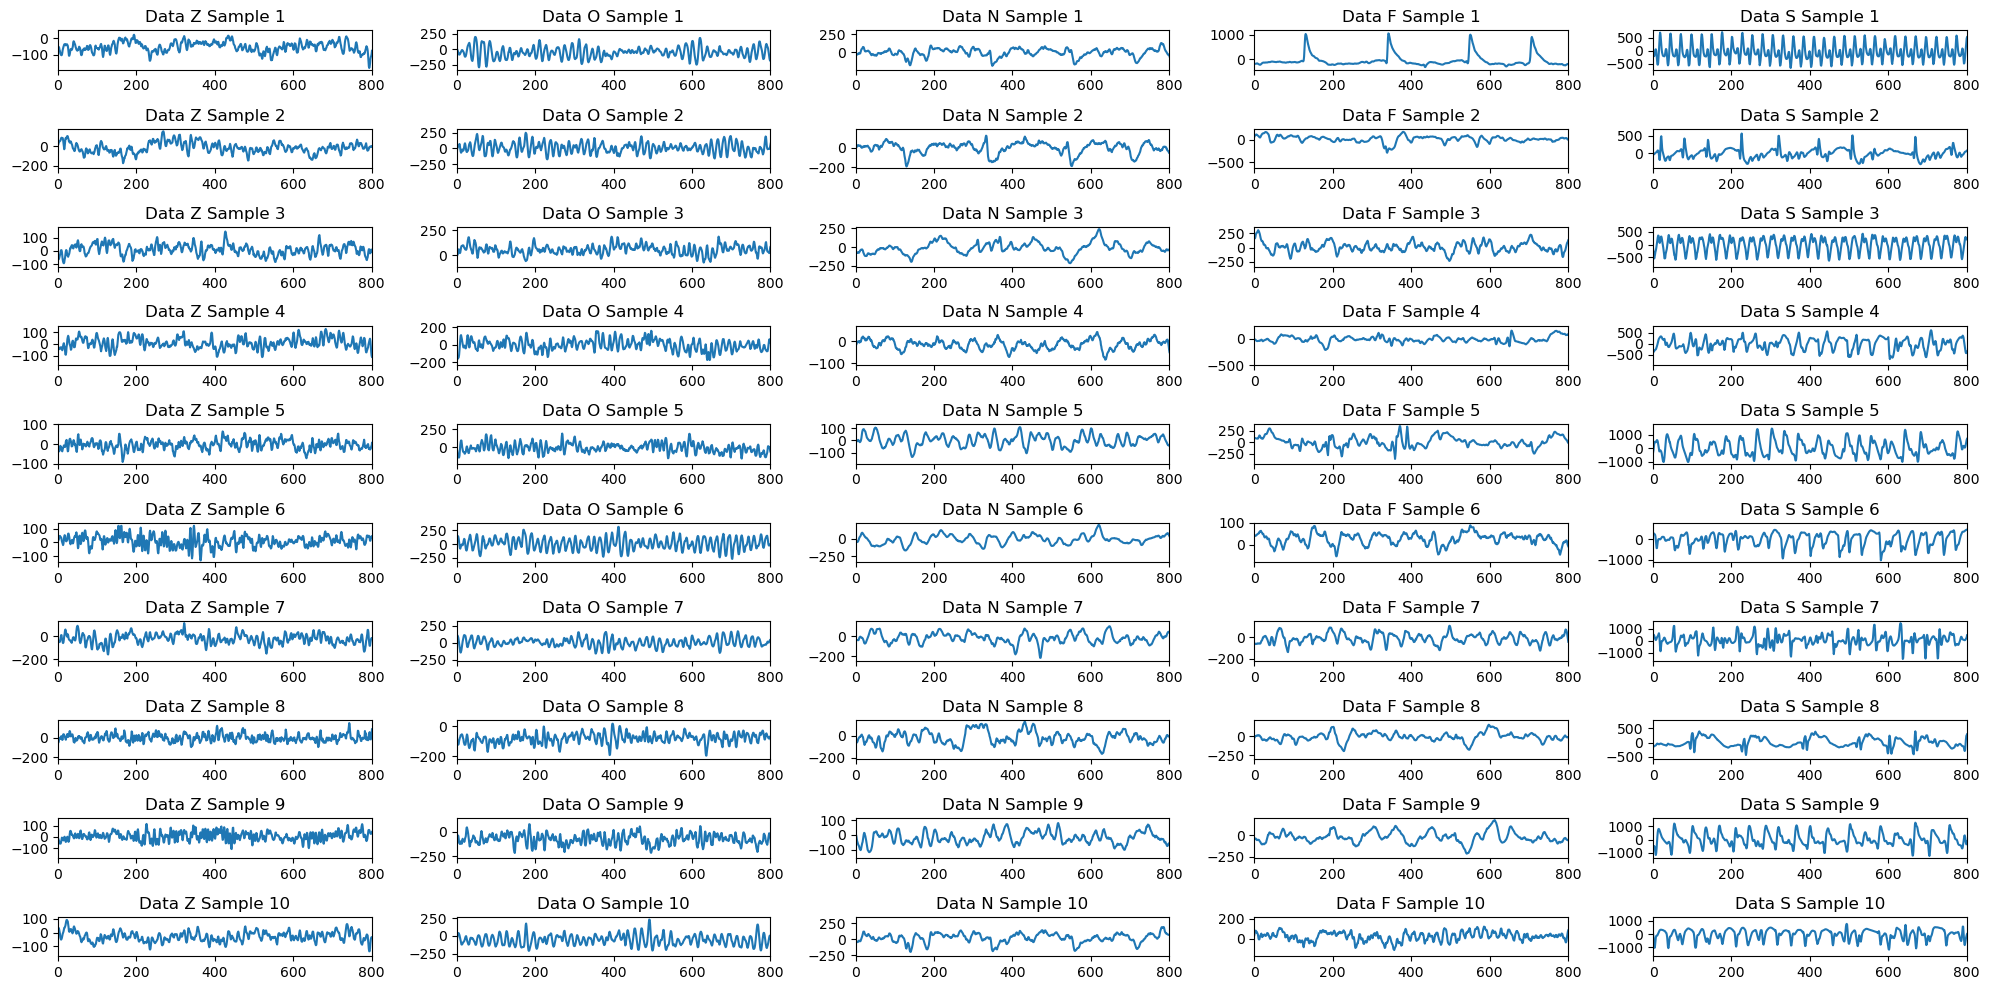

In [21]:
samples_to_plot = 10

# also plot the data in the time domain
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot time domain data for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(data_dict[class_name][i])
        axs[i, col].set_xlim(0, 800)
        axs[i, col].set_title(f'Data {class_name} Sample {i+1}')

plt.tight_layout()
plt.show()

#### Plotting FFT's

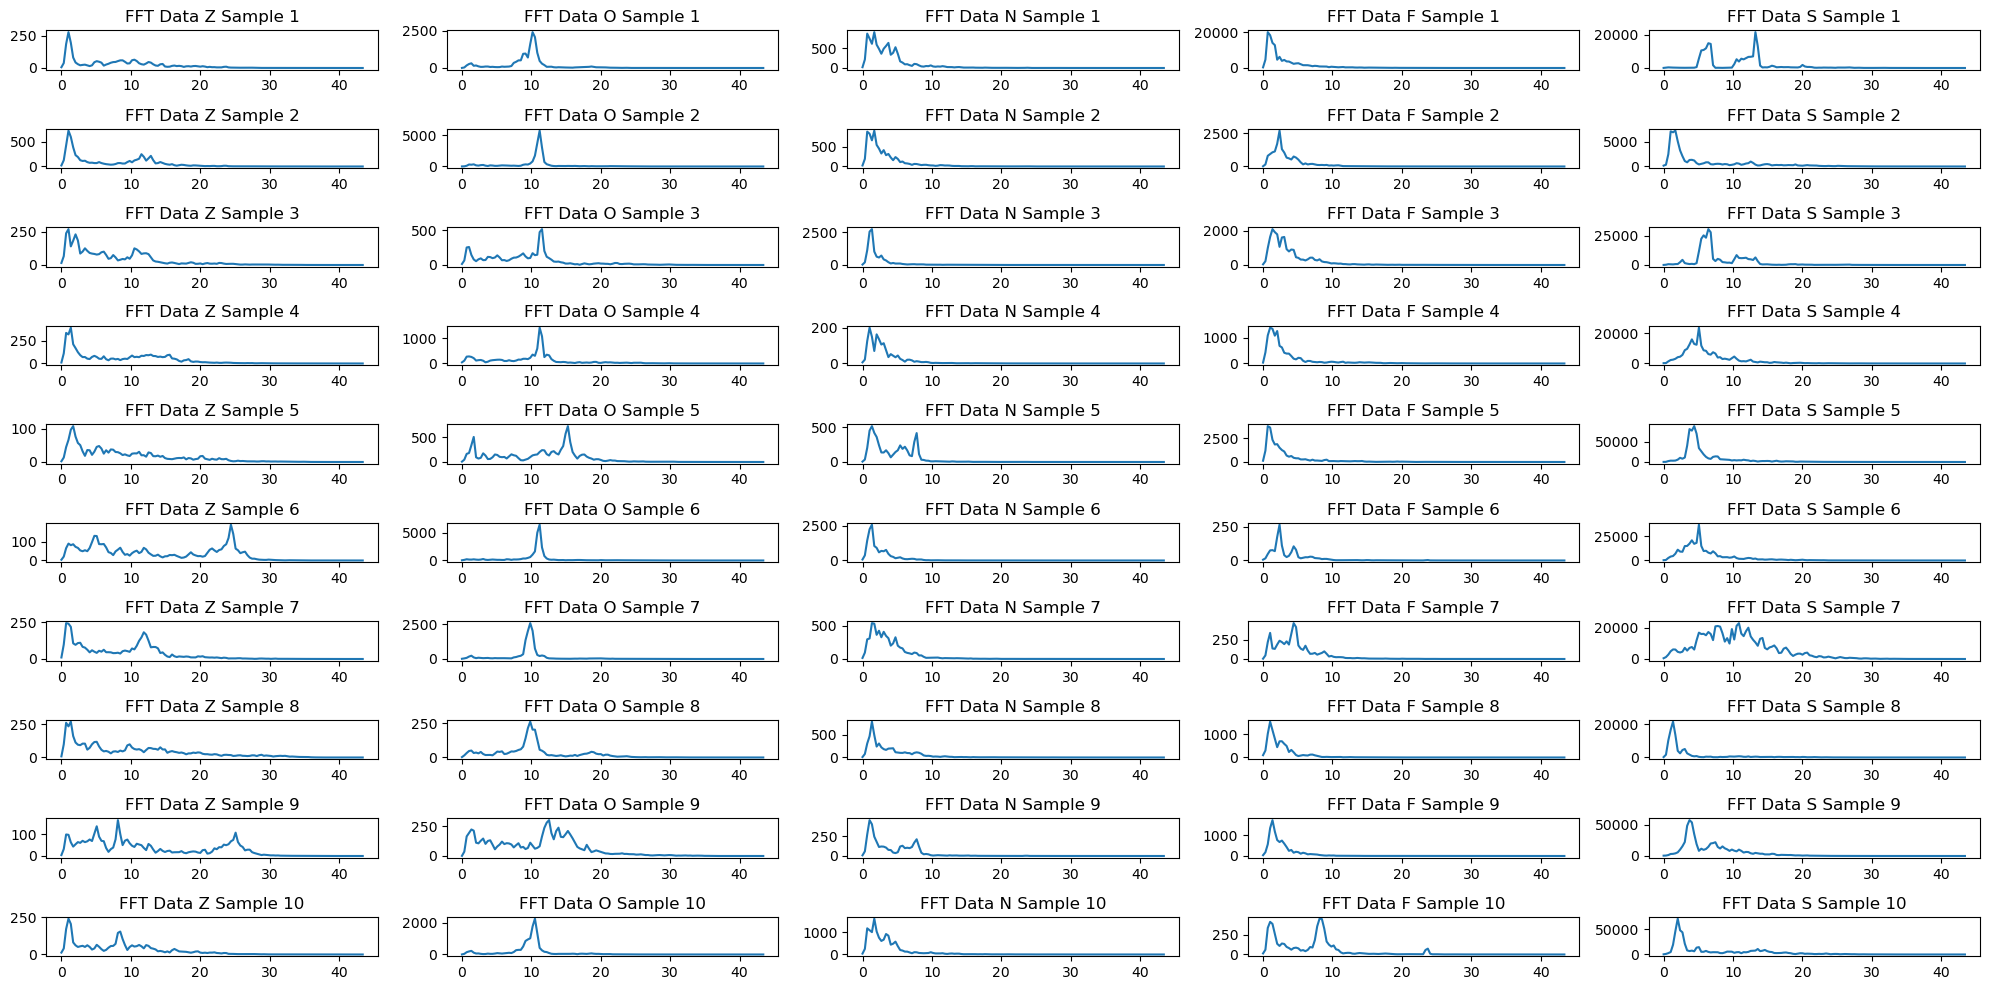

In [22]:
fig, axs = plt.subplots(samples_to_plot, 5, figsize=(20, 10))

# Plot FFTs for each dataset
for i in range(samples_to_plot):
    for col, class_name in enumerate(data_dict.keys()):
        axs[i, col].plot(frequencies, psd_dict[class_name][i])
        axs[i, col].set_title(f'FFT Data {class_name} Sample {i+1}')

# Adjust layout
plt.tight_layout()
plt.show()

### Doing some feature engineering
The main features i aim to extract are:

- the power of the EEG on each of the main literature frequency bands (delta, theta, alpha, beta, gamma);
- and the relative power of each of these bands;

Maybe i will also try to extract some other features like the Hjorth parameters, the fractal dimension and the entropy...

In [ ]:
def band_power(frequencies, psd, band):
    """ Calcula a potência dentro de uma banda de frequência específica """
    band_idx = np.logical_and(frequencies >= band[0], frequencies <= band[1])  
    return np.trapz(psd[band_idx], frequencies[band_idx])

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 40)
}

band_powers_df_dict = {}

for key, psd_list in psd_dict.items():
    band_powers_df_dict[key] = pd.DataFrame(
        {band: [band_power(frequencies, psd, bands[band]) for psd in psd_list] for band in bands}
        )

# print(band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

(100, 5)


In [28]:
norm_band_powers_df_dict = {}

for key, band_powers_df in band_powers_df_dict.items():
    norm_band_powers_df_dict[key] = band_powers_df.div(band_powers_df.sum(axis=1), axis=0)

# print(norm_band_powers_df_dict["Z"].shape) # (100, 5), 5 band powers per sample (100 samples)

#### Visualizing the features on a 3d point cloud

In [29]:
import plotly.express as px
import pandas as pd

# combining data onto single df (plotly express requirement)
all_classes_df = pd.concat([
    band_powers_df.assign(Class=key) for key, band_powers_df in band_powers_df_dict.items()
])

classes_to_be_plotted = ["Delta", "Alpha", "Beta"]

# scatter matrix instead of 3d scatter plot
fig = px.scatter_matrix(
    all_classes_df,
    dimensions = bands.keys(),
    color='Class',  # Color by class
    title='3D Scatter Plot of Band Powers',
    # labels={'Delta': 'Delta Power', 'Theta': 'Theta Power', 'Alpha': 'Alpha Power'}
)

fig.show()

### Now trying to do some classifiers, with the 4 different feature sets separately

#### Separating data between train and test

In [31]:
# Separating data into train and test sets for all feature sets

# Time-domain data
time_data = {
    key: data for key, data in data_dict.items()
}

# Frequency-domain data (Power Spectral Density)
frequency_data = {
    key: psd for key, psd in psd_dict.items()
}

# Band powers
band_power_data = {
    key: band_powers_df for key, band_powers_df in band_powers_df_dict.items()
}

# Normalized band powers
normalized_band_power_data = {
    key: norm_band_powers_df for key, norm_band_powers_df in norm_band_powers_df_dict.items()
}

# Function to split data into train and test sets
def split_data(data_dict, test_size=0.2, random_state=42):
    X = []
    y = []
    for label, data in data_dict.items():
        X.append(data)
        y.extend([label] * len(data))
    X = np.vstack(X)
    y = np.array(y)
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Splitting each feature set
X_train_time, X_test_time, y_train_time, y_test_time = split_data(time_data)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = split_data(frequency_data)
X_train_band, X_test_band, y_train_band, y_test_band = split_data(band_power_data)
X_train_norm_band, X_test_norm_band, y_train_norm_band, y_test_norm_band = split_data(normalized_band_power_data)

# Print shapes of the splits for verification
print("Time-domain data:", X_train_time.shape, X_test_time.shape)
print("Frequency-domain data:", X_train_freq.shape, X_test_freq.shape)
print("Band power data:", X_train_band.shape, X_test_band.shape)
print("Normalized band power data:", X_train_norm_band.shape, X_test_norm_band.shape)

Time-domain data: (400, 4097) (100, 4097)
Frequency-domain data: (400, 129) (100, 129)
Band power data: (400, 5) (100, 5)
Normalized band power data: (400, 5) (100, 5)


#### Setting and training the classifiers

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Function to create a basic MLP model
def create_mlp(input_dim, num_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, feature_name):
    # Encode labels
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    # One-hot encode labels
    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)
    
    # Create and train the model
    model = create_mlp(X_train.shape[1], num_classes=y_train_categorical.shape[1])
    model.fit(X_train, y_train_categorical, epochs=40, batch_size=32, verbose=1)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)
    print(f"{feature_name} - Test Accuracy: {accuracy:.4f}")
    
    # Generate classification report
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))

# Train and evaluate classifiers for each feature set
train_and_evaluate(X_train_time, X_test_time, y_train_time, y_test_time, "Time-domain data")
train_and_evaluate(X_train_freq, X_test_freq, y_train_freq, y_test_freq, "Frequency-domain data")
train_and_evaluate(X_train_band, X_test_band, y_train_band, y_test_band, "Band power data")
train_and_evaluate(X_train_norm_band, X_test_norm_band, y_train_norm_band, y_test_norm_band, "Normalized band power data")

Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2544 - loss: 11.5441
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2806 - loss: 11.5099
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3331 - loss: 10.6636
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2835 - loss: 11.4748
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2764 - loss: 11.6531
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2740 - loss: 11.6884
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3121 - loss: 11.0872
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2928 - loss: 11.3283
Epoch 9/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2882 - loss: 11.4610
Epoch 10/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2914 - loss: 11.3767
Epoch 11/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3168 - loss: 10.9448
Epoch 12/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3622 - loss: 10.0744
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3087 - loss: 11.0259
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3487 - loss: 10.3763
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3516 - loss: 10.3306
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3355 - loss: 10.4409
Epoch 9/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3535 - loss: 9.5484
Epoch 10/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3912 - loss: 8.6454
Epoch 11/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3515 - loss: 10.2438
Epoch 12/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3705 - loss: 10.0440
Epoch 13/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3483 - loss: 10.2398
Epoch 14/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3339 - loss: 10.5396
Epoch 15/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3370 - l

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4854 - loss: 1.5174
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4907 - loss: 1.4746
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4803 - loss: 1.4259
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5083 - loss: 1.3474
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5129 - loss: 1.2760
Epoch 9/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5190 - loss: 1.1934
Epoch 10/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5215 - loss: 1.1559
Epoch 11/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5549 - loss: 1.0889
Epoch 12/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5965 - loss: 1.0334
Epoch 13/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6086 - loss: 1.0094
Epoch 14/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6462 - loss: 0.9721
Epoch 15/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6721 - loss: 0.91

### Conclusions?